# Facial Emotion Recognition using `FER` in PySpark

### A case study in scalable emotion recognition and possible biases therein using PySpark

**Authors:** Peter Kováč, Mateusz Szewczyk, Sara Ademović, Denis Hoxha

In [1]:
# Packages necessary:
import sys
%run packages.py

In this notebook, we will explore:
- The `FER` Python package and its methods of Facial Emotion Recognition in a scalable setting in PySpark
- Applying `FER` to images from URLs
- The effects of colour and other factors not related to emotion on `FER`
- Applying `FER` to greyscale, labelled images
- Scalable image processing and the utilisation of PySpark and `FER` on a large volume of data
- The accuracy and other metrics of the algorithm

In [2]:
import findspark
findspark.init("/usr/local/spark/")

from pyspark.sql import SparkSession
from pyspark.context import SparkContext

spark = SparkSession.builder \
   .master("local[8]") \
   .appName("FER-TeamKovac") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[8] appName=FER-TeamKovac>

In [3]:
# Package imports 

import tensorflow # Image analysis models (keras)
import pandas as pd # Visualisation purposes
%matplotlib inline
import matplotlib.pyplot as plt # Plots
import matplotlib.patches as mpatches
import numpy as np # Arrays
from fer import FER # Facial Emotion Recognition
import requests # HTTP 
import urllib.request # Downloading images
import time # Measuring time it takes to perform tasks

# Images
import cv2 # Colour bias
import io
from io import StringIO, BytesIO # Reading raw data from binary
import skimage # Image downloades
from skimage import data, io, filters
from PIL import Image 

# PySpark SQL Functions
from pyspark.sql.functions import udf, col, lit, rand, monotonically_increasing_id, row_number, when
from pyspark.sql.types import StringType, FloatType, IntegerType
from pyspark.sql.window import Window

# Model evaluation
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns # Confusion Matrix Visualisation

import os
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR) # Disabling tensorflow WARNING
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disabling tensorflow WARNING

Given that we started with the [Google facial expression comparison dataset](https://research.google/tools/datasets/google-facial-expression/), on which we write in more detail in the project report, we will use an image from it to show the basic functioning of the `FER` package we are going to employ in this project. (*More about the FER package can be read [here](https://pypi.org/project/fer/)*) and the copyright to it can be found at the bottom of this notebook.

First, we'll use one of the images from the dataset:

[{'box': (355, 247, 151, 151), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.12, 'happy': 0.0, 'sad': 0.86, 'surprise': 0.0, 'neutral': 0.02}}]


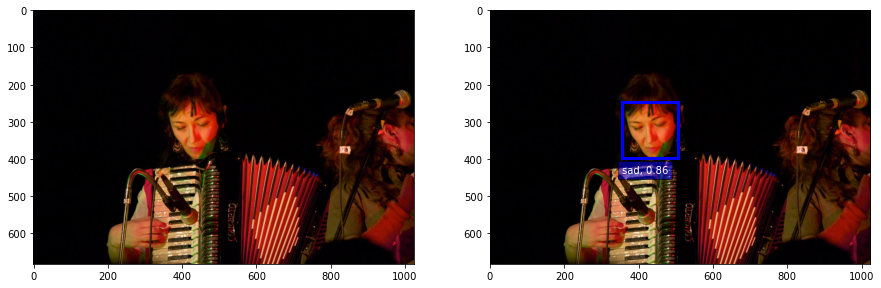

In [4]:
url1 = "https://farm6.staticflickr.com/5216/5504155540_142bd330cc_b.jpg" # URL1

plt_1 = plt.figure(figsize=(15, 5)) # We'll have two subplots

first = skimage.io.imread(url1) # We read the image into a NumPy array from its URL address

emo_detector = FER(mtcnn=True) # Setting up a basic emotion detector
captured_emotions = emo_detector.detect_emotions(first) # All detected emotions on the picture
dominant_emotion, emotion_score = emo_detector.top_emotion(first) # Dominant emotion

print(captured_emotions)

# First image
plt.subplot(1, 2, 1)
plt.imshow(first)

# Second image
plt.subplot(1, 2, 2)
plt.imshow(first)

emo_colors = {"angry":"red", # Dictionary to assign colors to emotions from FER
             "disgust": "brown", 
             "fear":"black", 
             "happy": "green", 
             "sad": "blue", "surprise": "yellow", 
             "neutral": "grey"} 

loc = captured_emotions[0]["box"] # Face Box
rect=mpatches.Rectangle((loc[0],loc[1]),loc[2],loc[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion],
                        linewidth = 3)
plt.gca().add_patch(rect) # Add the colored box into the pic
            
# Dominant Emotion:
plt.text(loc[0], loc[1]+loc[3]+40, dominant_emotion + ", " + str(emotion_score), 
                 c="white", bbox=dict(facecolor=emo_colors[dominant_emotion], alpha=0.5))

plt.show()

This code chunk is, obviously, a lot to unpack, so, step-by-step:
 - First, we read the image into a 3-dimensional `NumPy` array (which `FER` takes as an input) directly from its URL using the `skimage.io.imread` function. The array contains the pixels on the image and the information about their content and color.
 - Then, with `FER()`, we set up an emotion detector model and using the `.detect_emotions()` and `.top_emotion()` methods, we use it to scan the image first for faces and then detect emotions which are present.
 - As can be seen above the plot, the function returns the coordinates of the face box and the emotions detected within that very box, with probabilities assigned to each, picking out the top emotion with its score, which we saved. 
 
The algorithm also works with more faces on the picture, as we will demonstrate here:

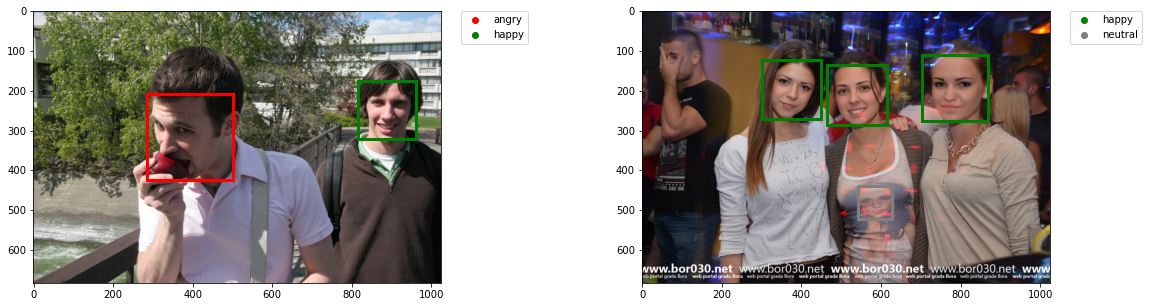

In [5]:
def boxes_emotions(url):
    
    try: # In case the image does not exist
        test_image_one = skimage.io.imread(url) # Turn image into array from URL

        emo_detector = FER(mtcnn=True)
        captured_emotions = emo_detector.detect_emotions(test_image_one)

        emotions = []

        # Dominant emotion per box
        for dicto in captured_emotions:
            dominant = max(dicto['emotions'].values())
            for emotion, score in dicto['emotions'].items():
                if score == dominant:
                    emotions.append(emotion) # Find dominant emotion PER box!

        emo_colors = {"angry":"red", 
         "disgust": "brown", 
         "fear":"black", 
         "happy": "green", 
         "sad": "blue", "surprise": "yellow", 
         "neutral": "grey"} # Dictionary to assign colors to emotions

        locs=[]
        for i in range(len(captured_emotions)):
            loc=captured_emotions[i]["box"]
            locs.append(loc) # Locations of all face boxes on the picture

        stream = requests.get(url, stream=True).raw
        with Image.open(stream) as image:
            plt.imshow(image) # Plotting the image from URL

        for i in range(len(locs)):
            rect=mpatches.Rectangle((locs[i][0],locs[i][1]),locs[i][2],locs[i][3], 
                                    fill = False,
                                    color = emo_colors[emotions[i]], # Colors for emotions
                                    linewidth = 3)
            plt.gca().add_patch(rect) # Add the colored boxes into the pic
        
        # Last - Add a legend
        new_list = list()
        for emotion in emotions:
            if emotion not in new_list:
                new_list.append(emotion)
        
        color_map = list()
        key_map = list()
        
        for key in emo_colors.keys():
            if key in new_list:
                color = emo_colors[key]
                if color not in color_map:
                    color_map.append(color)
                    key_map.append(key)
                    
        markers = [plt.Line2D([0,0],[0,0],color = color, marker='o', linestyle='') for color in color_map]
        plt.legend(markers, key_map, numpoints=1, bbox_to_anchor=(1.05, 1),
                                 loc='upper left', borderaxespad=0.)
        
       # plt.show()
        
    except:
            print('Invalid image - Try a different URL.')
            
plt_2 = plt.figure(figsize=(20, 5)) # We'll have two subplots again

plt.subplot(1, 2, 1)
boxes_emotions("https://farm1.staticflickr.com/62/153848218_ecc73d4443_b.jpg")

plt.subplot(1, 2, 2)
boxes_emotions("https://farm4.staticflickr.com/3884/14391680239_743d85b82d_b.jpg")

As can be expected, it's not without its flaws and sometimes works maybe a little bit *too* well (with the picture on the right detecting the face on the T-Shirt as a real face taken into account).

It might be noteworthy to add that this whole process is done without downloading a single image, simply reading URLs with requests and turning them into an acceptable (`NumPy`) format for the algorithm to process.

*Note: both of the URLs are, again, taken from the Google dataset*.

---
The function does not, however, explicitly specify how the dominant emotion on the picture is determined, leading us to ask questions about the effects of other factors, such as, for example, colour, on the resulting sentiment analysis of the image.

For further inspection, we will have to download one of the images to perform color transformations on it:

In [6]:
url2 = "https://farm4.staticflickr.com/3679/12137399835_d9075d3194_b.jpg" # URL2
urllib.request.urlretrieve(url2, "./pictures/test.jpg") # Downloading with a HTTP request

('./pictures/test.jpg', <http.client.HTTPMessage at 0x7f5d406041f0>)

We will perform three transformations on the image in total, turning it blue, grey and green and then running `FER` on it.

In [7]:
# First image emotion recognition - Coloured
test_image_one = plt.imread("./pictures/test.jpg") # Classic plt.imread method
emo_detector_1 = FER(mtcnn=True)
captured_emotions_1 = emo_detector_1.detect_emotions(test_image_one)
dominant_emotion_1, emotion_score_1 = emo_detector_1.top_emotion(test_image_one)
loc = captured_emotions_1[0]["box"] # Face Box

# Second image emotion recognition - Blue
test_image_two = cv2.imread("./pictures/test.jpg", cv2.IMREAD_COLOR) # Read the picture in BLUE
emo_detector_2 = FER(mtcnn=True)
captured_emotions_2 = emo_detector_2.detect_emotions(test_image_two)
dominant_emotion_2, emotion_score_2 = emo_detector_2.top_emotion(test_image_two)
loc_2 = captured_emotions_2[0]["box"] # Face Box

# Third image emotion recognition - Greyscale
jako = cv2.imread("./pictures/test.jpg", cv2.IMREAD_GRAYSCALE) # 2D Array as grayscale image
grayscale_image = np.dstack([jako, jako, jako]) # Making it a 3-dimesnional array
emo_detector_3 = FER(mtcnn=True)
captured_emotions_3 = emo_detector_3.detect_emotions(grayscale_image)
dominant_emotion_3, emotion_score_3 = emo_detector_3.top_emotion(grayscale_image)
loc_3 = captured_emotions_3[0]["box"] # Face Box

# Fourth image emotion recognition - Green Filter
greenfilter  = np.full((734,1024,3), (0,255,175), np.uint8) # Same shape filter as the original image
fused_img  = cv2.addWeighted(test_image_one, 0.8, greenfilter, 0.2, 0) # Putting a green filter on the original, coloured image
emo_detector_4 = FER(mtcnn=True)
captured_emotions_4 = emo_detector_4.detect_emotions(fused_img)
dominant_emotion_4, emotion_score_4 = emo_detector_4.top_emotion(fused_img)
loc_4 = captured_emotions_4[0]["box"] # Face Box

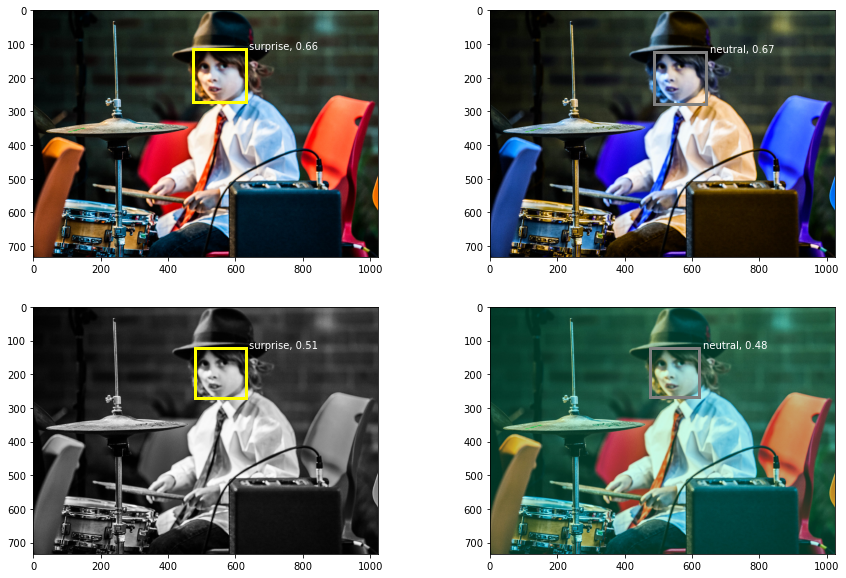

Emotions on the colored picture are: {'angry': 0.01, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.11, 'sad': 0.03, 'surprise': 0.66, 'neutral': 0.16}
Emotions on the blue picture are: {'angry': 0.0, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.04, 'sad': 0.02, 'surprise': 0.22, 'neutral': 0.67}
Emotions on the grey picture are: {'angry': 0.01, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.14, 'sad': 0.01, 'surprise': 0.51, 'neutral': 0.3}
Emotions on the green picture are: {'angry': 0.0, 'disgust': 0.0, 'fear': 0.06, 'happy': 0.03, 'sad': 0.01, 'surprise': 0.41, 'neutral': 0.48} 



In [8]:
# Plot everything:
import matplotlib.patches as mpatches
plt_1 = plt.figure(figsize=(15, 10)) # Whole plot

# First image
plt.subplot(2, 2, 1)
plt.imshow(test_image_one)
# Face Box 1
rect=mpatches.Rectangle((loc[0],loc[1]),loc[2],loc[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion_1],
                        linewidth = 3)
plt.gca().add_patch(rect)
plt.text(loc[0]+loc[2]+10, loc[1], dominant_emotion_1 + ", " + str(emotion_score_1), c="white")

# Second image
plt.subplot(2, 2, 2)
plt.imshow(test_image_two)
# Face Box 2
rect=mpatches.Rectangle((loc_2[0],loc_2[1]),loc_2[2],loc_2[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion_2],
                        linewidth = 3)
plt.gca().add_patch(rect)
plt.text(loc_2[0]+loc_2[2]+10, loc_2[1], dominant_emotion_2 + ", " + str(emotion_score_2), c="white")

# Third image
plt.subplot(2, 2, 3)
plt.imshow(grayscale_image, cmap=plt.get_cmap("gray"))
rect=mpatches.Rectangle((loc_3[0],loc_3[1]),loc_3[2],loc_3[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion_3],
                        linewidth = 3)
plt.gca().add_patch(rect)
plt.text(loc_3[0]+loc_3[2]+10, loc_3[1], dominant_emotion_3 + ", " + str(emotion_score_3), c="white")

# Fourth image
plt.subplot(2, 2, 4)
plt.imshow(fused_img)
rect=mpatches.Rectangle((loc_4[0],loc_4[1]),loc_4[2],loc_4[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion_4],
                        linewidth = 3)
plt.gca().add_patch(rect)
plt.text(loc_4[0]+loc_4[2]+10, loc_4[1], dominant_emotion_4 + ", " + str(emotion_score_4), c="white")

plt.show()

print("Emotions on the colored picture are: " + str(captured_emotions_1[0]["emotions"]))
print("Emotions on the blue picture are: " + str(captured_emotions_2[0]["emotions"]))
print("Emotions on the grey picture are: " + str(captured_emotions_3[0]["emotions"]))
print("Emotions on the green picture are: " + str(captured_emotions_4[0]["emotions"]), "\n")

This result alone is remarkable - a simple transformation, like putting a green filter on the image (with the help of `NumPy`), changes the dominant emotion within the face box, and therefore on the whole image. We visualise this effect of color on emotion detection below, with the help of `pandas`:

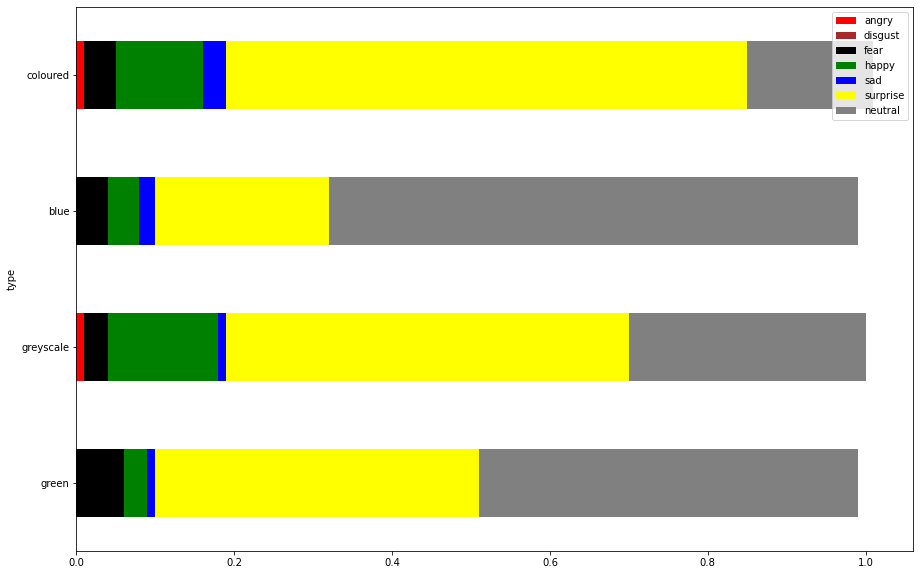

In [9]:
# Visualising the different effect of colour filters on a picture:
emo_list = []
emo_list.append(captured_emotions_1[0]["emotions"])
emo_list.append(captured_emotions_2[0]["emotions"])
emo_list.append(captured_emotions_3[0]["emotions"])
emo_list.append(captured_emotions_4[0]["emotions"])

emo_df = pd.DataFrame(emo_list) # Dataframe of emotion scores on the pictures

# Inserting the picture type
idx = 0
new_col = ["coloured", "blue", "greyscale", "green"] 
emo_df.insert(loc=idx, column='type', value=new_col)

my_colors= ["red", "brown", "black", "green", "blue", "yellow", "grey"]
emo_df.plot('type',[1,2,3,4,5,6,7],kind = 'barh', stacked=1, color = my_colors, figsize=(15,10)).invert_yaxis()

pass

This gives us a hint of how important color is when conducting emotion detection with `FER`. 

Color playing such an important role in emotion detection opens the door for all kinds of biases, be it when doing sentiment analysis on a larger picture with more faces (e.g. classifying darker images a certain way), or even when considering racial differences, where it might classify certain racial groups into more tendential emotional categories.

Due to this realisation, we chose to stop using the first dataset and continue with the Black and White [FER2013](https://www.kaggle.com/msambare/fer2013) dataset to avoid the possibility of bias introduced by colored images.

---
## Image and data pre-processing

For pre-processing, we created a smaller sample of our dataset, using the `random` package in Python. We do not, however, include this step here, since it would require us to include the entire dataset of over 20000 images, which would increase the file size and even the unzipping time of the project remarkably.

We created both the "sample" and "sample_small" folders and pasted the same, randomly selected 70 pictures from accross the categories into them.

We then resized the pictures (only in the "sample" folder) using the `cv2` library (as can be seen in the chunk below). We show the effects of resizing on our algorithm in a separate notebook in the "./pictures" folder called `resizing.ipynb`, where the accuracy of the model is compared using both original (48x48) and resized images (224x224). 

*Note: `resizing.ipynb` also includes code used to randomly picked our sample, for demonstrational purposes only.*

### Rezisizing the images

To resize images we use the **cv2** library and overwrite the smaller images in `sample`:

In [12]:
import cv2
sample_path = "./pictures/FER/sample"
img_size = 224

Classes = ["angry", "disgust", "fear","happy","neutral", "sad", "surprise"]

def resize_Images():
    for category in Classes:
        path_img = os.path.join(sample_path, category)
        for img in os.listdir(path_img):
            try:
                img_array = cv2.imread(os.path.join(path_img, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                cv2.imwrite(os.path.join(path_img, img), new_array)
            except Exception as e:
                pass

Last but not least, we have to call the function `resize_Images()` and then we are ready!

In [13]:
resize_Images()

---
## Reading the Data

We now read the (already resized) pictures with labels into a Spark dataframe, accordingly named `df`:

In [14]:
img_dir_test = "./pictures/FER/sample"

# Read each folder into a separate df first
angry = spark.read.format("binaryFile").load(img_dir_test + "/angry").withColumn("label", lit("angry"))
disgust = spark.read.format("binaryFile").load(img_dir_test + "/disgust").withColumn("label", lit("disgust"))
fear = spark.read.format("binaryFile").load(img_dir_test + "/fear").withColumn("label", lit("fear"))
happy = spark.read.format("binaryFile").load(img_dir_test + "/happy").withColumn("label", lit("happy"))
neutral = spark.read.format("binaryFile").load(img_dir_test + "/neutral").withColumn("label", lit("neutral"))
sad = spark.read.format("binaryFile").load(img_dir_test + "/sad").withColumn("label", lit("sad"))
surprise = spark.read.format("binaryFile").load(img_dir_test + "/surprise").withColumn("label", lit("surprise"))

df = angry.union(disgust).union(fear).union(happy).union(neutral).union(sad).union(surprise) # Join them
df = df.orderBy(rand()) # Shuffle the pictures randomly
df = df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1) # Index

df = df.select("id", "path", "content", "label") # Change the columns order
df.select("id", "label").show(5, truncate = False)

print('The number of images in the dataframe is:', df.count())

+---+-----+
|id |label|
+---+-----+
|0  |angry|
|1  |angry|
|2  |sad  |
|3  |angry|
|4  |sad  |
+---+-----+
only showing top 5 rows

The number of images in the dataframe is: 70


As is apparent from the code, we read the labelled pictures by first making a separate dataframe for each of them and then joined them all together with the `.union` method, shuffled them using the `rand()` function and added an index column to keep track. Above you can see the first five images with their original labels.

Please note that we read the images using `binaryFile`, a format from which we'll further transform them into `np.array`, a format on which the `FER` function works.

Let's display one of them:

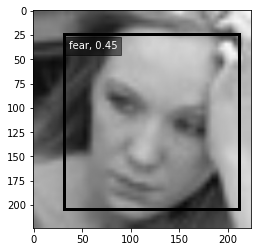

In [15]:
def box_emotion(raw):
    
    try: # In case the image does not exist
        test_image_one = np.asarray(Image.open(BytesIO(raw)).convert('RGB')) # Turn image into array from binary

        emo_detector = FER(mtcnn=True)
        captured_emotions = emo_detector.detect_emotions(test_image_one)
        dominant_emotion = emo_detector.top_emotion(test_image_one)

        emo_colors = {"angry":"red", 
         "disgust": "brown", 
         "fear":"black", 
         "happy": "green", 
         "sad": "blue", "surprise": "yellow", 
         "neutral": "grey"} # Dictionary to assign colors to emotions

        plt.imshow(test_image_one) # Plotting the image from path
            
        loc = captured_emotions[0]["box"] # Face Box
        rect=mpatches.Rectangle((loc[0],loc[1]),loc[2],loc[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion[0]],
                        linewidth = 3)
        plt.gca().add_patch(rect) # Add the colored boxes into the pic
            
        # Dominant Emotion:
        plt.text(loc[0]+5, loc[1]+15, dominant_emotion[0] + ", " + str(dominant_emotion[1]), 
                 c="white", bbox=dict(facecolor=emo_colors[dominant_emotion[0]], alpha=0.5))
        
        plt.show()
        
    except:
            print('Invalid image - Try a different picture.')
            
raw = df.collect()[1]["content"] # Loading the binary file
box_emotion(raw)

We picked the second image of our dataframe and this time read it into a `NumPy` array using `BytesIO` and `Pillow.Image`. We will use these to help us determine the emotions on each image in our dataframes. 

---

## Model implementation

Now that our dataset is *ready to go*, we have to implement the `FER` function over the entire dataset - we will do this with Spark `UDF`s [(User Defined Functions)](https://spark.apache.org/docs/latest/sql-ref-functions-udf-scalar.html):

In [16]:
# Dominant emotion on the picture
def emotion_binary_detection(raw):
    try:
        test_image = np.asarray(Image.open(BytesIO(raw)).convert('RGB'))
        emo_detector = FER(mtcnn=True)
        captured_emotions = emo_detector.detect_emotions(test_image)

        dominant_emotion = emo_detector.top_emotion(test_image)
        return dominant_emotion[0]
    except:
        return np.nan
    
# Probability score of the dominant emotion
def emotion_binary_prob(raw):
    try:
        test_image = np.asarray(Image.open(BytesIO(raw)).convert('RGB'))
        emo_detector = FER(mtcnn=True)
        captured_emotions = emo_detector.detect_emotions(test_image)

        dominant_emotion = emo_detector.top_emotion(test_image)
        return dominant_emotion[1]
    except:
        return np.nan

In [17]:
# Make them into spark UDFs
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType, FloatType, IntegerType
udf_emo_binary = udf(lambda x:emotion_binary_detection(x),StringType() )
udf_prob_binary = udf(lambda x:emotion_binary_prob(x),FloatType() )

We created two functions:

- `emotion_binary_detection()` for detecting the dominant emotion on the picture (returns a string output)
- `emotion_binary_prob()` for detecting the probability of the dominant emotion being the actual one (float output)
    - This function serves more as an information indicator to us than of being of use for the model itself - in case of there being mistakes, for example.
    
We then turned these functions into UDFs, returning a `StringType` for the dominant emotion and a `FloatType` for its probability.

We will now apply it to the dataframe:

In [18]:
predicted = df.withColumn("prediction", 
                     udf_emo_binary(col("content"))).withColumn("probability", 
                                                                udf_prob_binary(col("content")))

As the model will have both correct and incorrect guesses, we will also introduce an additional column to keep track of this (which will help us measure the models accuracy) - this function will simply compare the `prediction` and `label` columns to assess whether the algorithm made a correct guess.

We will show the first 10 predictions:

In [19]:
predicted_correct = predicted.withColumn('correct', 
                            when((col("prediction") == col("label")) , 1).otherwise(0))

predicted_correct.select("id", "label", "prediction", "probability", "correct").show(10, truncate = False)

+---+--------+----------+-----------+-------+
|id |label   |prediction|probability|correct|
+---+--------+----------+-----------+-------+
|0  |angry   |angry     |0.98       |1      |
|1  |angry   |fear      |0.45       |0      |
|2  |sad     |sad       |0.31       |1      |
|3  |angry   |angry     |0.56       |1      |
|4  |sad     |angry     |0.73       |0      |
|5  |disgust |disgust   |0.57       |1      |
|6  |disgust |null      |null       |0      |
|7  |happy   |happy     |0.99       |1      |
|8  |fear    |happy     |0.5        |0      |
|9  |surprise|neutral   |0.34       |0      |
+---+--------+----------+-----------+-------+
only showing top 10 rows



---

### A quick sidenote on scalability

To demonstrate the workings of the model in regards to scalability, we will compare how it works with 10 vs. with 70 pictures to compare the time it takes to predict all the images in both:

In [20]:
tmp = time.time()

first_10 = df.limit(10) # We take the first 10 rows 

# Predicting the first 10 pictures
first_10_predicted = first_10.withColumn("prediction", 
                     udf_emo_binary(col("content"))).withColumn("probability", 
                                                                udf_prob_binary(col("content")))

# Which predictions are correct?
ten = first_10_predicted.withColumn('correct', 
                            when((col("prediction") == col("label")) , 1).otherwise(0))

tmp1 = time.time() - tmp
tmp3 = time.time()

# Predicting all 70 pictures
predicted = df.withColumn("prediction", 
                     udf_emo_binary(col("content"))).withColumn("probability", 
                                                                udf_prob_binary(col("content")))

# Which predictions are correct?
predicted_correct = predicted.withColumn('correct', 
                            when((col("prediction") == col("label")) , 1).otherwise(0))

tmp2 = time.time() - tmp3

print("Predicting 10 pictures takes around", round(tmp1,5), "seconds, while predicting 70 takes", round(tmp2,5),
     ". \nThere's a relative difference of", round((abs(tmp2/tmp1 - 1))*100,2), "% between the two.")

print("\nIt takes", round((tmp2/tmp1)*100,2), "% of the time of processing 10 pictures to process all 70 of them!\n")

Predicting 10 pictures takes around 0.10328 seconds, while predicting 70 takes 0.05815 . 
There's a relative difference of 43.7 % between the two.

It takes 56.3 % of the time of processing 10 pictures to process all 70 of them!



As we can see, the difference (which however varies with each run) is small - sometimes it even takes *less* time to predict *more* images.

We thus hope to call our implemented solution as scalable - predicting more pictures does not mean more processing time, provided that the memory is sufficient. The only worrying part could be the volume of the input images (which is also why we used a smaller sample out of the dataset).

---
## Assessing Model Accuracy

We now want to score our model on how well it did with labelled data - we can do this in multiple ways:

#### 1. Use the `correct` column to calculate model accuracy by hand

In [21]:
# Remove null values
a = predicted_correct.na.drop().count()
b = predicted_correct.where(predicted_correct.correct == 1).count() 

In [22]:
print("The length of the dataframe without null values is:",a)
print("The number of correct predictions was:", b)
print("The percentage of correct predictions was:", round(b/a, 4)*100,"%.\n")

The length of the dataframe without null values is: 58
The number of correct predictions was: 40
The percentage of correct predictions was: 68.97 %.



We also see that our model failed to classify some of the images (these are not taken into account when calculating model accuracy):

In [ ]:
print("The final dataset includes", predicted_correct.count() - a, 
      "null values.\nThis is, in total,", round((predicted_correct.count() - a)/a, 4)*100, "% of all the images.\n")

The final dataset includes 12 null values.
This is, in total, 20.69 % of all the images.



#### 2. Use `MulticlassMetrics` from PySpark

Aquired from [here](https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html), this is a tool for assessing model accuracy for multi-class classification models (which is precisely our case). 

Due to the fact that this method works with the `RDD` type and float numbers, we still have some more pre-processing to do:

In [ ]:
label = predicted.select("prediction", "label") # We select our columns of interest
label = label.na.drop() # Remove null values!

# We turn the string types in both columns into floats:
label_pred = label.withColumn("prediction_num", when(col("prediction")=='angry', 
                                        float(0)).when(col("prediction")=='disgust', 
                                                       float(1)).when(col("prediction")=='fear', 
                                                       float(2)).when(col("prediction")=='happy', 
                                                       float(3)).when(col("prediction")=='neutral', 
                                                       float(4)).when(col("prediction")=='sad', 
                                                       float(5)).otherwise(float(6)))

num = label_pred.withColumn("label_num", when(col("label")=='angry', 
                                        float(0)).when(col("label")=='disgust', 
                                                       float(1)).when(col("label")=='fear', 
                                                       float(2)).when(col("label")=='happy', 
                                                       float(3)).when(col("label")=='neutral', 
                                                       float(4)).when(col("label")=='sad', 
                                                       float(5)).otherwise(float(6)))
# And we create an RDD
num_rdd = num.select("prediction_num", "label_num")
num_rdd = num_rdd.rdd

In the chunk above, we first dropped the null values and then created a corresponding column for both `prediction` and `label`, giving us a 4-column dataframe:

In [ ]:
num.show(5)

+----------+-----+--------------+---------+
|prediction|label|prediction_num|label_num|
+----------+-----+--------------+---------+
|     angry|angry|           0.0|      0.0|
|      fear|angry|           2.0|      0.0|
|       sad|  sad|           5.0|      5.0|
|     angry|angry|           0.0|      0.0|
|     angry|  sad|           0.0|      5.0|
+----------+-----+--------------+---------+
only showing top 5 rows



And then ran `MulticlassMetrics` on the RDD we extracted to give us our metrics. 

*Note that we still had to remove the null values which occured due to the algorithm not working 100% of the time!*

In [ ]:
metrics = MulticlassMetrics(num_rdd)

In [ ]:
print("The model's estimated accuracy is", round(metrics.accuracy, 4)*100, "%.\n")

The model's estimated accuracy is 68.97 %.



The first metric (accuracy) gives us the same result as our manual method did.

#### Confusion Matrix

Another evaluator we'll inspect is the **Confusion Matrix** of the labelled dataset. It includes both the labels and the predictions, telling us what predictions (correct or wrong) the model made:

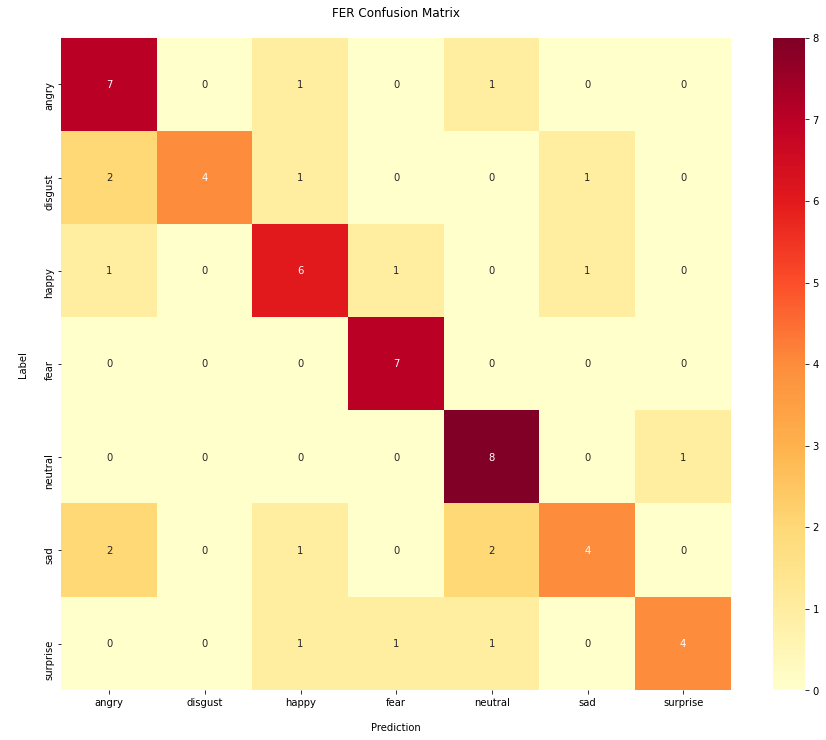

In [ ]:
# From https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
confusion = metrics.confusionMatrix().toArray()
plt_confusion = plt.figure(figsize=(15, 12))

ax = sns.heatmap(confusion, annot=True, cmap='YlOrRd')

# Setting titles
ax.set_title('FER Confusion Matrix\n');
ax.set_xlabel('\nPrediction')
ax.set_ylabel('\nLabel \n');

# Setting x- and y- axis labels
ax.xaxis.set_ticklabels(["angry", "disgust", "happy", "fear", "neutral", "sad", "surprise"])
ax.yaxis.set_ticklabels(["angry", "disgust", "happy", "fear", "neutral", "sad", "surprise"])

plt.show()

As is clear from the visualisation, a majority of the predictions were correct. The confusion matrix tells us, among other things:
- The most correct guesses can be attributed to the category `neutral`, giving it the highest **recall** value of all
- The category `disgust` included no "false positives", i.e., each prediction labelled `disgust` was correct
    - This gives `disgust` the higest precision value (100%), which does not however mean that all pictures labelled `disgust` were predicted correctly (only 50%)
- `Angry` had the highest false positive rate, with the algorithm often confusing it for `sad` or `disgust`, giving it the lowest precision of all

In [ ]:
print(round(metrics.recall(4.0), 4)*100, "% of pictures labelled neutral were classified correctly.")
print(round(metrics.precision(1.0), 4)*100, "% of predictions of disgust were correct guesses, but only", round(metrics.recall(1.0), 4)*100, 
      "% of pictures labelled disgust were classified correctly.")
print("Angry had a false positive rate of roughly", round(metrics.falsePositiveRate(0.0),4)*100, "% and a precision of", round(metrics.precision(0.0), 3)*100, "%.\n")

88.89 % of pictures labelled neutral were classified correctly.
100.0 % of predictions of disgust were correct guesses, but only 50.0 % of pictures labelled disgust were classified correctly.
Angry had a false positive rate of roughly 10.2 % and a precision of 58.3 %.



We can also extract the *weighted* (averaged) metrics like recall and precision from the `metrics` variable, in the following way:

In [ ]:
print("The model had a:",
     "\n- Weighted precision of:", round(metrics.weightedPrecision,4)*100, "%",
     "\n- Weighted recall of:", round(metrics.weightedRecall,4)*100, "%",
     "\n- Weighted false positive rate of:", round(metrics.weightedFalsePositiveRate,4)*100, "%\n")

The model had a: 
- Weighted precision of: 71.89 % 
- Weighted recall of: 68.97 % 
- Weighted false positive rate of: 5.46 %



All in all giving our algorithm a positive rating, which is not however, to say it's perfect, especially with the rather high number of null values it has produced. Incorrect classifications, be it false predictions or null values, could be the source of make-or-break dillemas when such an algorithm would be put into commercial or scientific use.

---
# Conclusions

In this exploration of Emotion Recognition with PySpark, we have concluded that:
- The `FER` package can be used rather reliably to estimate the emotion on images, as well as detect the faces present
- `FER` can be used scalably on a larger amount of data without increasing computational time
- It can predict images well (with an accuracy of almost 69%), provided that the input images are well-sized and of high quality

We can also conclude that
- `FER` *is* subject to **colour bias** and this aspect should therefore be treated with care (preferrably using greyscale)
- Emotion detection is not foolproof and does have mistakes, especially when not being able to detect any emotion within an image, and/or locate the face-box.
---

### LIME

We further comment on the methodology behind `FER` and its inner workings, mechanisms and limitations in the `lime.ipynb` file which is located in the "pictures" folder using [LIME](https://github.com/marcotcr/lime), Local Interpretable Model-Agnostic Explanations on our pictures.

---

### Copyright
The following chunk contains the copyright for the `FER` package:

In [ ]:
# Copyright (c) 2018 Justin Shenk
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.